<a href="https://colab.research.google.com/github/plaban1981/Pytorch/blob/master/pytorch_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Download the code zip file

In [2]:
!wget https://pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com/pytorch-object-detection/pytorch-object-detection.zip
!unzip -qq pytorch-object-detection.zip
%cd pytorch-object-detection

--2022-04-02 12:34:43--  https://pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com/pytorch-object-detection/pytorch-object-detection.zip
Resolving pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com)... 52.218.210.1
Connecting to pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com)|52.218.210.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 401785 (392K) [application/zip]
Saving to: ‘pytorch-object-detection.zip’

pytorch-object-dete 100%[===================>] 392.37K   596KB/s    in 0.7s    

2022-04-02 12:34:45 (596 KB/s) - ‘pytorch-object-detection.zip’ saved [401785/401785]

/content/pytorch-object-detection/pytorch-object-detection


### Import Packages

In [3]:
from torchvision.models import detection
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import torch
import cv2

### Function to display images in Jupyter Notebooks and Google Colab

In [4]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Implementing our PyTorch object detection script


In [5]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", type=str, required=True,
# 	help="path to the input image")
# ap.add_argument("-m", "--model", type=str, default="frcnn-resnet",
# 	choices=["frcnn-resnet", "frcnn-mobilenet", "retinanet"],
# 	help="name of the object detection model")
# ap.add_argument("-l", "--labels", type=str, default="coco_classes.pickle",
# 	help="path to file containing list of categories in COCO dataset")
# ap.add_argument("-c", "--confidence", type=float, default=0.5,
# 	help="minimum probability to filter weak detections")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "image": "images/example_01.jpg",
    "model": "frcnn-resnet",
    "labels": "coco_classes.pickle",
    "confidence": 0.5
}

In [6]:
# set the device we will be using to run the model
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the list of categories in the COCO dataset and then generate a
# set of bounding box colors for each class
CLASSES = pickle.loads(open(args["labels"], "rb").read())
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

In [7]:
# initialize a dictionary containing model name and it's corresponding 
# torchvision function call
MODELS = {
	"frcnn-resnet": detection.fasterrcnn_resnet50_fpn,
	"frcnn-mobilenet": detection.fasterrcnn_mobilenet_v3_large_320_fpn,
	"retinanet": detection.retinanet_resnet50_fpn
}

# load the model and set it to evaluation mode
model = MODELS[args["model"]](pretrained=True, progress=True,
	num_classes=len(CLASSES), pretrained_backbone=True).to(DEVICE)
model.eval()
print("")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [8]:
# load the image from disk
image = cv2.imread(args["image"])
orig = image.copy()

# convert the image from BGR to RGB channel ordering and change the
# image from channels last to channels first ordering
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.transpose((2, 0, 1))

# add the batch dimension, scale the raw pixel intensities to the
# range [0, 1], and convert the image to a floating point tensor
image = np.expand_dims(image, axis=0)
image = image / 255.0
image = torch.FloatTensor(image)

# send the input to the device and pass the it through the network to
# get the detections and predictions
image = image.to(DEVICE)
detections = model(image)[0]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[INFO] car: 99.54%
[INFO] car: 99.18%
[INFO] person: 85.76%


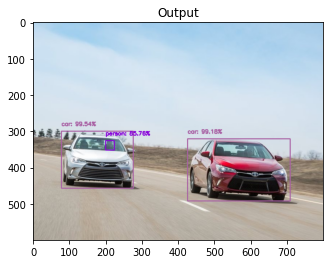

In [9]:
# loop over the detections
for i in range(0, len(detections["boxes"])):
	# extract the confidence (i.e., probability) associated with the
	# prediction
	confidence = detections["scores"][i]

	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > args["confidence"]:
		# extract the index of the class label from the detections,
		# then compute the (x, y)-coordinates of the bounding box
		# for the object
		idx = int(detections["labels"][i])
		box = detections["boxes"][i].detach().cpu().numpy()
		(startX, startY, endX, endY) = box.astype("int")

		# display the prediction to our terminal
		label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
		print("[INFO] {}".format(label))

		# draw the bounding box and label on the image
		cv2.rectangle(orig, (startX, startY), (endX, endY),
			COLORS[idx], 2)
		y = startY - 15 if startY - 15 > 15 else startY + 15
		cv2.putText(orig, label, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)

# show the output image
plt_imshow("Output", orig)

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [PyTorch object detection with pre-trained networks](https://www.pyimagesearch.com/2021/08/02/pytorch-object-detection-with-pre-trained-networks/) published on 2021-08-02.

# Code License Agreement
```
Copyright (c) 2021 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```